In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader




In [2]:
! pip install torch

In [3]:
import random
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
set_seed(40)

In [4]:
#Load Data
partially_processed_path = '../data/fully_processed/full_PCA.csv'
dataset = pd.read_csv(partially_processed_path)
encoded = True

#print(dataset.columns)
#print(dataset)

X, y = dataset.drop(["name", "is_all_star"], axis=1), dataset["is_all_star"]
#One-Hot Encode Player Position
if not encoded:
    encoded = pd.get_dummies(X["positions"], prefix="POS")
    X = pd.merge(left=X.drop("positions", axis=1), right=encoded, left_index=True, right_index=True)

print(X.columns, y.head())

Index(['pca_0', 'pca_1', 'pca_2', 'pca_3'], dtype='object') 0    0
1    1
2    0
3    0
4    0
Name: is_all_star, dtype: int64


In [5]:
#split dataset into 70/15/15 for training, testing, validation
SEED = 69
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=test_ratio+val_ratio)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=val_ratio/(val_ratio + test_ratio))


#convert data to tensors
X_train, X_test, X_val = torch.LongTensor(X_train.values), torch.LongTensor(X_test.values), torch.LongTensor(X_val.values)
y_train, y_test, y_val = torch.LongTensor(y_train.values), torch.LongTensor(y_test.values), torch.LongTensor(y_val.values)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

torch.Size([5698, 4]) torch.Size([1900, 4]) torch.Size([1900, 4])
torch.Size([5698]) torch.Size([1900]) torch.Size([1900])


In [6]:
class dataset(Dataset):
  def __init__(self,X,y):
    self.X = X.float()
    self.y = y.float()
    self.length = self.X.shape[0]
 
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]
  def __len__(self):
    return self.length

In [7]:
class AllStarClassifier(nn.Module):
    def __init__(self, LAYER_1=30, LAYER_2=10, LAYER_3 = 10):
      super(AllStarClassifier, self).__init__()
      # dense layers
      self.layer1 = nn.Linear(LAYER_1, LAYER_2)
      self.layer2 = nn.Linear(LAYER_2,  LAYER_3)
      self.layer3 = nn.Linear(LAYER_3,  1)

    def forward(self, X):

      X = self.layer1(X)
      X = F.relu(X)
      X = self.layer2(X)
      X = F.relu(X)
      X = self.layer3(X)
      return torch.sigmoid(X)

In [8]:
loss_fn = nn.BCELoss()

learning_rate = 0.005
num_epochs = 15
batch_size = 32

In [9]:
train_set = dataset(X_train,y_train)
test_set = dataset(X_test,y_test)
val_set = dataset(X_val,y_val)
#DataLoader
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

In [10]:
def EvalNet(dev_loader, net):
    num_correct = 0
    epoch_accuracy = []
    epoch_loss = []
    for i,(X,y) in enumerate(dev_loader):
        output = net.forward(X)

        loss = loss_fn(output,y.reshape(-1,1))
        epoch_loss.append(loss.detach().numpy())

        accuracy = (output.reshape(-1).detach().numpy().round() == y.detach().numpy()).sum()/X.shape[0]
        epoch_accuracy.append(accuracy)
    eval_loss_list.append(sum(epoch_loss)/len(epoch_loss))
    eval_accuracy_list.append(sum(epoch_accuracy) / len(epoch_accuracy))
    print("Accuracy: %s" % (sum(epoch_accuracy) / len(epoch_accuracy)))
    return y

def Train(net, train_loader, n_iter, dev_loader, learning_rate=0.01):
  print("Start Training!")
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  for epoch in range(n_iter):
    total_loss = 0.0
    epoch_accuracy = []
    epoch_loss = []
    net.train()   #Put the network into training mode
    for i,(X,y) in tqdm.notebook.tqdm(enumerate(train_loader)):
      output = net(X)
      
      loss = loss_fn(output,y.reshape(-1,1))
      epoch_loss.append(loss.detach().numpy())

      accuracy = (output.reshape(-1).detach().numpy().round() == y.detach().numpy()).sum()/(X.shape[0])
      epoch_accuracy.append(accuracy)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      

    train_accuracy_list.append(sum(epoch_accuracy)/len(epoch_accuracy))
    train_loss_list.append(sum(epoch_loss)/len(epoch_loss))
    
    net.eval()
    with torch.no_grad():
      print(f"Loss on Train {epoch} = {sum(epoch_loss)/len(epoch_loss)}")
      EvalNet(dev_loader, net)
  return net

In [11]:
set_seed(100)

eval_loss_list = []
train_loss_list = []
eval_accuracy_list = []
train_accuracy_list = []

as_classifier = AllStarClassifier(LAYER_1=X_train.shape[1], LAYER_2=10, LAYER_3=10)
trained_nn = Train(as_classifier, train_loader, num_epochs, val_loader)


Start Training!


0it [00:00, ?it/s]

Loss on Train 0 = 0.4667288805351608
Accuracy: 0.937673611111111


0it [00:00, ?it/s]

Loss on Train 1 = 0.17926072575283294
Accuracy: 0.9423611111111111


0it [00:00, ?it/s]

Loss on Train 2 = 0.15150621994421806
Accuracy: 0.9444444444444444


0it [00:00, ?it/s]

Loss on Train 3 = 0.11684432140273152
Accuracy: 0.945486111111111


0it [00:00, ?it/s]

Loss on Train 4 = 0.10852022776926488
Accuracy: 0.9449652777777777


0it [00:00, ?it/s]

Loss on Train 5 = 0.10719005504945636
Accuracy: 0.9460069444444444


0it [00:00, ?it/s]

Loss on Train 6 = 0.09985047929358341
Accuracy: 0.9522569444444444


0it [00:00, ?it/s]

Loss on Train 7 = 0.09511419525370002
Accuracy: 0.9559027777777778


0it [00:00, ?it/s]

Loss on Train 8 = 0.10187661579912251
Accuracy: 0.970486111111111


0it [00:00, ?it/s]

Loss on Train 9 = 0.09476310178876839
Accuracy: 0.9710069444444444


0it [00:00, ?it/s]

Loss on Train 10 = 0.09263263157550662
Accuracy: 0.965625


0it [00:00, ?it/s]

Loss on Train 11 = 0.08830004819674032
Accuracy: 0.9699652777777777


0it [00:00, ?it/s]

Loss on Train 12 = 0.08706009890962205
Accuracy: 0.9699652777777777


0it [00:00, ?it/s]

Loss on Train 13 = 0.08772182480208368
Accuracy: 0.968923611111111


0it [00:00, ?it/s]

Loss on Train 14 = 0.0877959479281273
Accuracy: 0.9666666666666667


In [12]:
print(dir(tqdm.tqdm_notebook))
print('tqdm_notebook' in dir(tqdm))

['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
True


In [13]:
train_loss_list

[0.4667288805351608,
 0.17926072575283294,
 0.15150621994421806,
 0.11684432140273152,
 0.10852022776926488,
 0.10719005504945636,
 0.09985047929358341,
 0.09511419525370002,
 0.10187661579912251,
 0.09476310178876839,
 0.09263263157550662,
 0.08830004819674032,
 0.08706009890962205,
 0.08772182480208368,
 0.0877959479281273]

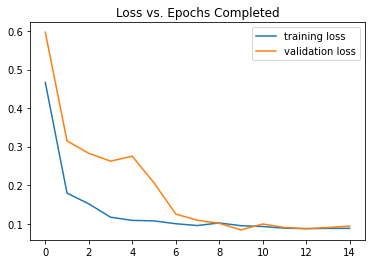

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_loss_list, label='training loss')
plt.plot(eval_loss_list, label='validation loss')
plt.title('Loss vs. Epochs Completed')
plt.legend()

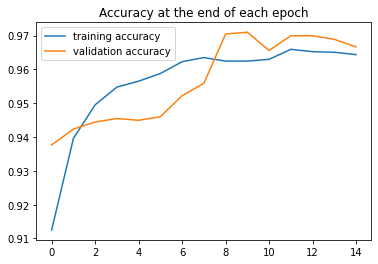

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_accuracy_list, label='training accuracy')
plt.plot(eval_accuracy_list, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()